# Model Training and Evaluation

## Loading the dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow
import keras
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, cross_validate, RandomizedSearchCV
import logging
import warnings
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import seaborn as sns
from sklearn.inspection import permutation_importance
import joblib

2024-11-11 12:36:39.560096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load in the training and test datasets
X_trainval = pd.read_csv('Data/X_trainval_utilitarian.csv')
y_trainval = pd.read_csv('Data/y_trainval_utilitarian.csv').values.ravel() # ravel to convert to 1D array
X_test = pd.read_csv('Data/X_test_utilitarian.csv')
y_test = pd.read_csv('Data/y_test_utilitarian.csv').values.ravel() # ravel to convert to 1D array

In [3]:
pd.set_option('display.max_columns', None)
X_trainval.head()

,PedPed,Barrier,NumberOfCharacters,DiffNumberOFCharacters,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,NumberOfLivesSaved,Finance_nols,ICT_nols,Industry_nols,Overall_nols,Research_nols,Skills_nols,Total_nols,Males_nols,Females_nols,Passengers_nols,Pedestrians_nols,AttributeLevel_More,CrossingSignal_1,CrossingSignal_2,Clusters_1,Clusters_2,Clusters_3
0,1,0,0.845076,-0.449067,1.894694,-0.436605,-0.437006,-0.437964,1.898027,-0.437596,-0.437237,-0.437748,-0.437297,-0.437018,4.223434,-0.437762,-0.437169,1.889421,-0.43736,-0.437544,-0.436515,-0.436645,-0.438072,-0.438222,0.807870,-0.203868,0.065141,1.001200,1.240846,0.192654,0.682665,0.514950,1.143918,0.438905,0.285340,2,0.797722,0.690334,0.730503,0.834899,0.952693,0.742719,0.880342,0.819175,1.033383,0.796188,0.721639,1,0,0,0,0,1
1,0,0,0.845076,1.339690,-0.437400,-0.436605,-0.437006,-0.437964,-0.436789,-0.437596,1.894088,-0.437748,-0.437297,-0.437018,-0.436861,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,1.901005,4.225389,1.899310,-0.438222,0.807870,-0.203868,0.065141,1.001200,1.240846,0.192654,0.682665,0.514950,1.143918,0.438905,0.285340,4,1.595665,1.380825,1.461203,1.669956,1.905463,1.485694,1.760934,1.638626,2.066930,1.592637,1.443514,1,0,0,0,0,1
2,1,0,0.169392,-1.343446,-0.437400,-0.436605,-0.437006,-0.437964,-0.436789,1.894391,1.894088,-0.437748,1.900932,-0.437018,1.893286,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,-0.436515,-0.436645,-0.438072,-0.438222,-0.161656,0.996578,1.257895,0.269309,0.301359,0.192654,-0.946007,-0.896214,-1.005525,-0.851211,-0.946646,-1,-0.354861,-0.425073,-0.411214,-0.375934,-0.381186,-0.371744,-0.148188,-0.146033,-0.153415,-0.192520,-0.112154,0,0,1,0,0,0
3,1,0,0.845076,0.445311,-0.437400,-0.436605,-0.437006,-0.437964,-0.436789,1.894391,1.894088,-0.437748,-0.437297,-0.437018,-0.436861,-0.437762,1.897445,-0.438582,-0.43736,-0.437544,1.901005,-0.436645,1.899310,-0.438222,0.807870,0.996578,0.065141,0.269309,-0.168385,0.192654,-0.632046,-0.675336,-0.457628,0.293474,-0.702728,3,1.196693,1.274595,1.095853,1.127169,1.000331,1.114207,0.612643,0.560944,0.737574,1.124759,0.483428,1,1,0,0,1,0
4,1,0,0.845076,1.339690,1.894694,1.899724,-0.437006,-0.437964,-0.436789,-0.437596,-0.437237,-0.437748,-0.437297,4.223385,-0.436861,-0.437762,-0.437169,-0.438582,-0.43736,-0.437544,-0.436515,1.894372,-0.438072,-0.438222,-0.161656,0.196280,0.065141,-0.462581,-0.638128,-0.213274,-0.700725,-0.699878,-0.647285,-0.620939,-0.705261,4,1.418344,1.487054,1.461203,1.335933,1.143247,1.386631,0.767627,0.729655,0.855185,0.915828,0.642601,1,1,0,0,1,0


In [5]:
# Count the distribution of the target variable
y_trainval_df = pd.DataFrame(y_trainval, columns=['Saved'])
y_trainval_df['Saved'].value_counts()

Saved
1    562094
0    562093
Name: count, dtype: int64

In [4]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold cross-validation

In [5]:
# Size of the training and test datasets
print(len(X_trainval), len(X_test))

1124187 281047


## Model Training, Evaluation and Comparisson

### Dummy Classifier

In [6]:
model_dc = DummyClassifier(strategy='uniform', random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores = cross_validate(model_dc, X_trainval, y_trainval, cv=kf, scoring=scoring)

results_dc = pd.DataFrame(scores)
results_dc.to_csv('Output/results_dc.csv')

print(f"Mean validation accuracy: {scores['test_accuracy'].mean()}")
print(f"Mean validation precision: {scores['test_precision'].mean()}")
print(f"Mean validation recall: {scores['test_recall'].mean()}")
print(f"Mean validation F1: {scores['test_f1'].mean()}")

Mean validation accuracy: 0.4997344747804413
Mean validation precision: 0.4997352946401606
Mean validation recall: 0.5004425422866902
Mean validation F1: 0.5000885254067599


### Binary Logistic Regression

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END C=1, class_weight=None, max_iter=200, penalty=l2, solver=lbfgs, tol=0.001; total time=  35.1s
[CV] END C=0.01, class_weight=None, max_iter=200, penalty=l1, solver=liblinear, tol=0.01; total time=  48.6s
[CV] END C=0.01, class_weight=None, max_iter=200, penalty=l1, solver=liblinear, tol=0.01; total time=  48.8s
[CV] END C=0.01, class_weight=None, max_iter=200, penalty=l1, solver=liblinear, tol=0.01; total time=  49.0s
[CV] END C=1, class_weight=None, max_iter=200, penalty=l2, solver=lbfgs, tol=0.001; total time=  12.8s
[CV] END C=1, class_weight=None, max_iter=200, penalty=l2, solver=lbfgs, tol=0.001; total time=  18.8s
[CV] END C=0.1, class_weight=None, max_iter=500, penalty=l1, solver=liblinear, tol=0.01; total time=  27.5s
[CV] END C=0.1, class_weight=None, max_iter=500, penalty=l1, solver=liblinear, tol=0.01; total time=  29.9s
[CV] END C=0.1, class_weight=None, max_iter=500, penalty=l1, solver=liblinear, tol=0.01

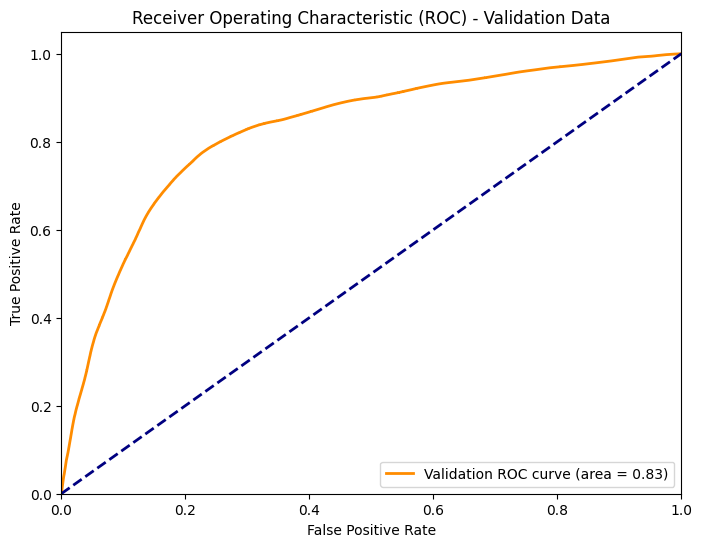

Model evaluation completed.


In [7]:
param_dist = [
    {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2], 'class_weight': [None, 'balanced']},
    {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['saga', 'lbfgs'], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2], 'class_weight': [None, 'balanced']},
    {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0.1, 0.5, 0.7, 0.9], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2], 'class_weight': [None, 'balanced']},
    {'penalty': [None], 'solver': ['saga'], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2], 'class_weight': [None, 'balanced']}]

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize Decision Tree model
model_lr = LogisticRegression(random_state=42)

# Initialize Random Search with 5-fold cross-validation and 100 iterations
random_search = RandomizedSearchCV(estimator=model_lr, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Fit Grid Search on the training data
random_search.fit(X_trainval, y_trainval)

# Get the best model from grid search
best_model_lr = random_search.best_estimator_
joblib.dump(best_model_lr, 'Output/best_model_lr.pkl')

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_lr = pd.DataFrame(random_search.cv_results_)
results_lr.to_csv('Output/results_lr.csv', index=False)

# Generate predicted probabilities for the validation data using cross-validation
y_proba_val_lr = cross_val_predict(best_model_lr, X_trainval, y_trainval, cv=kf, method='predict_proba')[:, 1]

# Compute ROC curve and ROC area for validation data
fpr_val_lr, tpr_val_lr, thresholds_val_lr = roc_curve(y_trainval, y_proba_val_lr)
roc_auc_val_lr = auc(fpr_val_lr, tpr_val_lr)

# Plotting the ROC curve for validation data
plt.figure(figsize=(8, 6))
plt.plot(fpr_val_lr, tpr_val_lr, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_lr.png')

plt.show()

print("Model evaluation completed.")

### Decision Tree (CART)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=20; total time= 1.1min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=20; total time= 1.1min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=20; total time= 1.1min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=10; total time= 1.1min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=10; total time=  44.9s
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=10; total time=  45.5s
[CV] END criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=20; total time=  52.6s
[CV] END criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=20; total time=  52.9s
[CV] END criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=20; total time= 1.0min
[CV

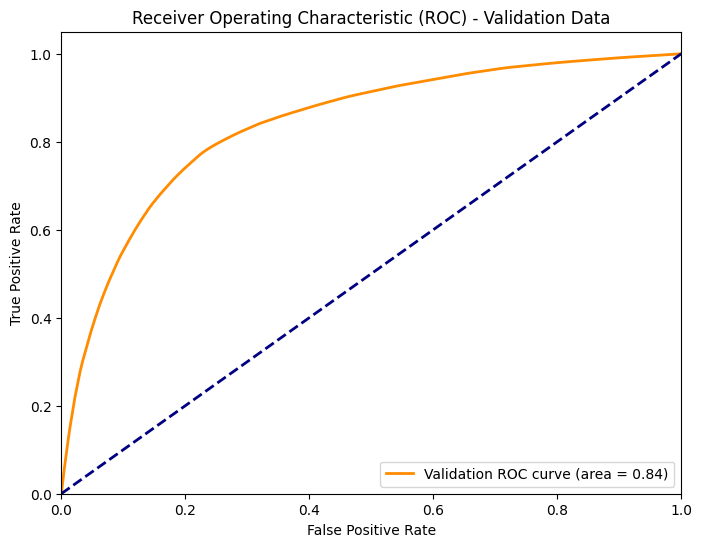

Model evaluation completed.


In [9]:
# Define the parameter grid for Grid Search
param_dist = {'criterion': ['gini', 'entropy'], # function to measure the quality of a split
              'max_depth': [10, 15, 20, 25, None], # maximum depth of the tree
              'min_samples_split': [10, 20, 30, 40], # minimum number of samples required to split an internal node
              'min_samples_leaf': [5, 10, 20, 30] # minimum number of samples allowed at a leaf node
}

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)

# Initialize Random Search with 5-fold cross-validation and 100 iterations
random_search = RandomizedSearchCV(estimator=model_dt, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Fit Grid Search on the training data
random_search.fit(X_trainval, y_trainval)

# Get the best model from grid search
best_model_dt = random_search.best_estimator_
joblib.dump(best_model_dt, 'Output/best_model_dt.pkl')

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_dt = pd.DataFrame(random_search.cv_results_)
results_dt.to_csv('Output/results_dt.csv', index=False)

# Generate predicted probabilities for the validation data using cross-validation
y_proba_val_dt = cross_val_predict(best_model_dt, X_trainval, y_trainval, cv=kf, method='predict_proba')[:, 1]

# Compute ROC curve and ROC area for validation data
fpr_val_dt, tpr_val_dt, thresholds_val_dt = roc_curve(y_trainval, y_proba_val_dt)
roc_auc_val_dt = auc(fpr_val_dt, tpr_val_dt)

# Plotting the ROC curve for validation data
plt.figure(figsize=(8, 6))
plt.plot(fpr_val_dt, tpr_val_dt, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_dt.png')

plt.show()

print("Model evaluation completed.")

### Random Forest

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END bootstrap=True, criterion=gini, max_depth=40, min_samples_leaf=50, min_samples_split=50, n_estimators=400; total time=41.2min
[CV] END bootstrap=False, criterion=entropy, max_depth=10, min_samples_leaf=30, min_samples_split=50, n_estimators=800; total time=51.0min
[CV] END bootstrap=False, criterion=entropy, max_depth=10, min_samples_leaf=30, min_samples_split=50, n_estimators=800; total time=51.0min
[CV] END bootstrap=False, criterion=entropy, max_depth=10, min_samples_leaf=30, min_samples_split=50, n_estimators=800; total time=51.1min
[CV] END bootstrap=True, criterion=gini, max_depth=40, min_samples_leaf=50, min_samples_split=50, n_estimators=400; total time=46.0min
[CV] END bootstrap=True, criterion=gini, max_depth=40, min_samples_leaf=50, min_samples_split=50, n_estimators=400; total time=98.4min
[CV] END bootstrap=False, criterion=gini, max_depth=30, min_samples_leaf=50, min_samples_split=40, n_estimators=400; 

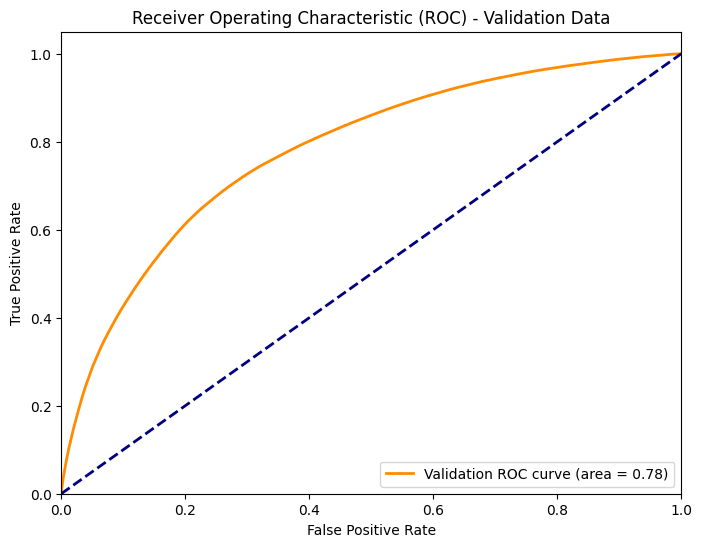

Model evaluation completed.


In [7]:
# Define the parameter grid for Grid Search
param_dist = {'criterion': ['gini', 'entropy'], # function to measure the quality of a split
              'bootstrap': [True, False], # method for sampling data points
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], # maximum depth of the tree
              'min_samples_split': [5, 10, 20, 30, 40, 50], # minimum number of samples required to split an internal node
              'min_samples_leaf': [5, 10, 20, 30, 40, 50], # minimum number of samples allowed at a leaf node
              'n_estimators': [100, 200, 400, 600, 800, 1000]} # number of trees in the forest

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize Decision Tree model
model_rf = RandomForestClassifier(random_state=42)

# Initialize Random Search with 5-fold cross-validation and 100 iterations
random_search = RandomizedSearchCV(estimator=model_rf, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Fit Grid Search on the training data
random_search.fit(X_trainval, y_trainval)

# Get the best model from grid search
best_model_rf = random_search.best_estimator_
joblib.dump(best_model_rf, 'Output/best_model_rf.pkl')

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_rf = pd.DataFrame(random_search.cv_results_)
results_rf.to_csv('Output/results_rf.csv', index=False)

# Generate predicted probabilities for the validation data using cross-validation
y_proba_val_rf = cross_val_predict(best_model_rf, X_trainval, y_trainval, cv=kf, method='predict_proba')[:, 1]

# Compute ROC curve and ROC area for validation data
fpr_val_rf, tpr_val_rf, thresholds_val_rf = roc_curve(y_trainval, y_proba_val_rf)
roc_auc_val_rf = auc(fpr_val_rf, tpr_val_rf)

# Plotting the ROC curve for validation data
plt.figure(figsize=(8, 6))
plt.plot(fpr_val_rf, tpr_val_rf, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_rf.png')

plt.show()

print("Model evaluation completed.")

### MLP (Neural Network)

In [37]:
def build_model(hidden_units, hidden_layers, activation, optimizers):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(X_trainval.shape[1],)))
    
    # Add hidden layers
    for _ in range(hidden_layers):
        model.add(layers.Dense(hidden_units))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizers, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6381 - loss: 0.6419
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7033 - loss: 0.5787
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7083 - loss: 0.5718
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7091 - loss: 0.5698
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7110 - loss: 0.5676
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7121 - loss: 0.5659
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7132 - loss: 0.5641
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7129 - loss: 0.5650
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7142 - loss: 0.5633
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7134 - loss: 0.5641
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7148 - loss: 0.5629
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy:

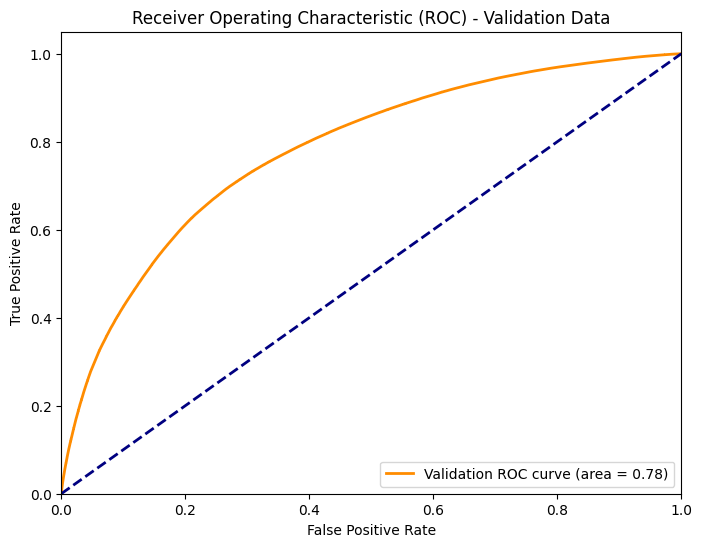

Model evaluation completed.


In [9]:
# Fit Wiedeman 2020 on the training data
model_wiedeman = KerasClassifier(model=build_model, hidden_units=64, hidden_layers=2, activation='relu', optimizers='rmsprop', epochs=50, batch_size=10_000, verbose=1)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores = cross_validate(model_wiedeman, X_trainval, y_trainval, cv=kf, scoring=scoring, return_train_score=True)

print(f"Mean training accuracy: {scores['train_accuracy'].mean()}")
print(f"Mean training precision: {scores['train_precision'].mean()}")
print(f"Mean training recall: {scores['train_recall'].mean()}")
print(f"Mean training F1: {scores['train_f1'].mean()}")
print(f"Mean training AUC: {scores['train_roc_auc'].mean()}")

print(f"Mean validation accuracy: {scores['test_accuracy'].mean()}")
print(f"Mean validation precision: {scores['test_precision'].mean()}")
print(f"Mean validation recall: {scores['test_recall'].mean()}")
print(f"Mean validation F1: {scores['test_f1'].mean()}")
print(f"Mean validation AUC: {scores['test_roc_auc'].mean()}")

results_wiedeman = pd.DataFrame(scores)
results_wiedeman.to_csv('Output/results_wiedeman.csv', index=False)

# Generate predicted probabilities for the validation data using cross-validation
y_proba_val_wiedeman = cross_val_predict(model_wiedeman, X_trainval, y_trainval, cv=kf, method='predict_proba')[:, 1]

# Compute ROC curve and ROC area for validation data
fpr_val_wiedeman, tpr_val_wiedeman, thresholds_val_wiedeman = roc_curve(y_trainval, y_proba_val_wiedeman)
roc_auc_val_wiedeman = auc(fpr_val_wiedeman, tpr_val_wiedeman)

# Plotting the ROC curve for validation data
plt.figure(figsize=(8, 6))
plt.plot(fpr_val_wiedeman, tpr_val_wiedeman, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_wiedeman:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_wiedeman.png')

plt.show()

print("Model evaluation completed.")

warnings.filterwarnings("ignore", category=UserWarning, message="``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


2024-11-10 18:46:47.015475: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 18:46:47.338633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 18:46:47.348984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 18:46:47.439486: I tensorflow/core/platform/cpu_featu

Epoch 1/50
Epoch 1/10
Epoch 1/10
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.5816 - loss: 0.6762
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.6022 - loss: 0.6627
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5679 - loss: 0.6981
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6804 - loss: 0.6025
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6898 - loss: 0.5960
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6828 - loss: 0.6021
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7013 - loss: 0.5839
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7023 - loss: 0.5831
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6992 - loss: 0.5860
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7071 - loss: 0.5780
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7047 - loss: 0.5794Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 

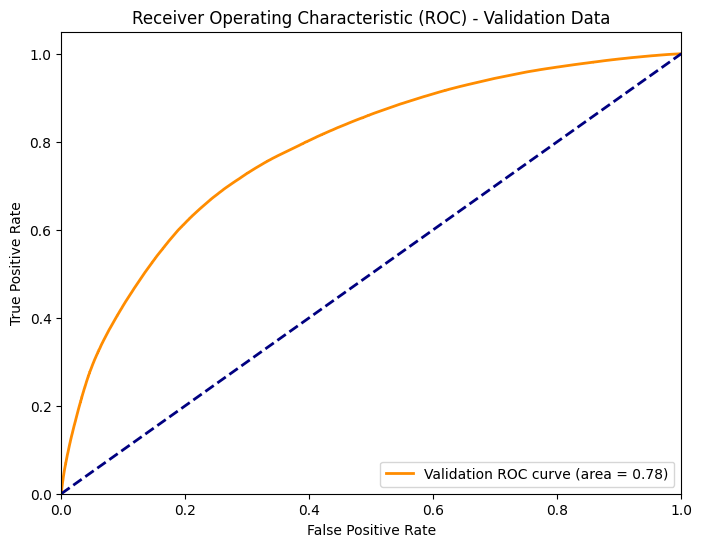

Grid search and model evaluation completed.


In [10]:
# Initialize KerasClassifier
model_mlp = KerasClassifier(model=build_model, verbose=1)

param_dist = {
    'model__hidden_units': [16, 32, 64, 128],              # Varying number of units in each hidden layer
    'model__hidden_layers': [1, 2, 3, 4],                  # Number of hidden layers
    'model__activation': ['relu', 'leaky_relu', 'tanh'],   # Activation functions for hidden layers
    'epochs': [10, 20, 30, 40, 50],                        # Number of training epochs
    'model__optimizers': ['adam', 'rmsprop']               # Optimizers
}

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize Random Search with 5-fold cross-validation and 100 iterations
random_search = RandomizedSearchCV(estimator=model_mlp, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Fit Grid Search on the training data
random_search.fit(X_trainval, y_trainval, batch_size=10_000, callbacks=[early_stopping], verbose=1)

# Get the best model from grid search
best_model_mlp = random_search.best_estimator_
joblib.dump(best_model_mlp, 'Output/best_model_mlp.pkl')

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_mlp = pd.DataFrame(random_search.cv_results_)
results_mlp.to_csv('Output/results_mlp.csv', index=False)

# Generate predicted probabilities for the validation data using cross-validation
y_proba_val_mlp = cross_val_predict(best_model_mlp, X_trainval, y_trainval, cv=kf, method='predict_proba')[:, 1]

# Compute ROC curve and ROC area for validation data
fpr_val_mlp, tpr_val_mlp, thresholds_val_mlp = roc_curve(y_trainval, y_proba_val_mlp)
roc_auc_val_mlp = auc(fpr_val_mlp, tpr_val_mlp)

# Plotting the ROC curve for validation data
plt.figure(figsize=(8, 6))
plt.plot(fpr_val_mlp, tpr_val_mlp, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_mlp.png')

plt.show()

print("Grid search and model evaluation completed.")

warnings.filterwarnings("ignore", category=UserWarning, message="``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.")

In [47]:
result_mlp = pd.read_csv('Output/results_mlp.csv')
best_model_mlp = results_mlp[results_mlp['rank_test_accuracy'] == 1]
best_model_mlp

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__optimizers,param_model__hidden_units,param_model__hidden_layers,param_model__activation,param_epochs,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_log_loss,split1_test_log_loss,split2_test_log_loss,mean_test_log_loss,std_test_log_loss,rank_test_log_loss,split0_train_log_loss,split1_train_log_loss,split2_train_log_loss,mean_train_log_loss,std_train_log_loss,split0_test_precision,split1_test_precision,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,mean_train_f1,std_train_f1,split0_test_auc,split1_test_auc,split2_test_auc,mean_test_auc,std_test_auc,rank_test_auc,split0_train_auc,split1_train_auc,split2_train_auc,mean_train_auc,std_train_auc
13,151.550431,17.839867,282.092876,20.252261,adam,32,2,relu,40,"{'model__optimizers': 'adam', 'model__hidden_u...",0.713815,0.71263,0.715039,0.713828,0.000984,1,0.715505,0.716243,0.714745,0.715498,0.000612,-0.564194,-0.564801,-0.563004,-0.564,0.000746,2,-0.561072,-0.560589,-0.561858,-0.561173,0.000523,0.714796,0.720212,0.719074,0.718027,0.002331,7,0.717115,0.723008,0.719071,0.719731,0.002451,0.710611,0.696814,0.705339,0.704255,0.005684,8,0.712251,0.70039,0.705118,0.70592,0.004875,0.712697,0.70832,0.71214,0.711053,0.001946,3,0.714675,0.711519,0.712026,0.71274,0.001384,0.780704,0.780003,0.781801,0.780836,0.00074,2,0.783659,0.78412,0.782836,0.783538,0.000531


Epoch 1/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5684 - loss: 0.7068 - val_accuracy: 0.6728 - val_loss: 0.6216
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6862 - loss: 0.5961 - val_accuracy: 0.6992 - val_loss: 0.5878
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7023 - loss: 0.5796 - val_accuracy: 0.7054 - val_loss: 0.5767
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7073 - loss: 0.5739 - val_accuracy: 0.7078 - val_loss: 0.5729
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7091 - loss: 0.5708 - val_accuracy: 0.7088 - val_loss: 0.5712
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7099 - loss: 0.5692 - val_accuracy: 0.7100 - val_loss: 0.5698
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7119 - loss: 0.5670 - val_accuracy: 0.7104 - val_loss: 0.5688
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7115 - loss: 0.5672 - val_accuracy: 0.7108 - v

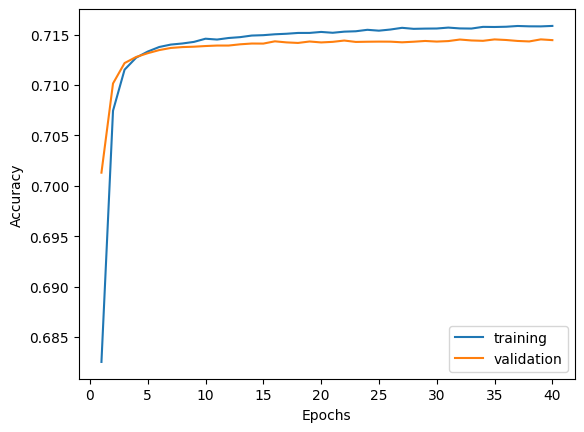

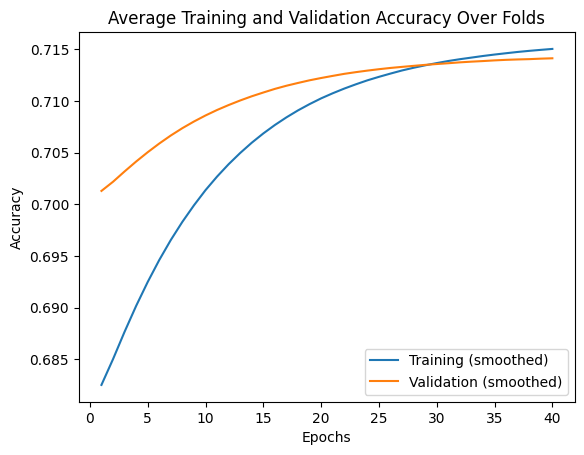

In [51]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

best_model = build_model(hidden_layers=best_model_mlp['param_model__hidden_layers'].values[0],
                             hidden_units=best_model_mlp['param_model__hidden_units'].values[0], 
                             activation=best_model_mlp['param_model__activation'].values[0], 
                             optimizers=best_model_mlp['param_model__optimizers'].values[0])

# Store histories of each fold
train_histories = []
val_histories = []

for train_index, val_index in kf.split(X_trainval, y_trainval):
    # Use .iloc to index by positions
    X_train_fold, X_val_fold = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train_fold, y_val_fold = y_trainval[train_index], y_trainval[val_index]
    
    # Train the model for the current fold
    history = best_model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=best_model_mlp['param_epochs'].values[0], batch_size=10_000)
    
    # Collect the accuracy history
    train_histories.append(history.history['accuracy'])
    val_histories.append(history.history['val_accuracy'])

# Calculate the average history for training and validation
train_histories = np.array(train_histories)
val_histories = np.array(val_histories)

avg_train_history = np.mean(train_histories, axis=0)
avg_val_history = np.mean(val_histories, axis=0)

# Smooth the averaged curves
smooth_avg_train_history = smooth_curve(avg_train_history)
smooth_avg_val_history = smooth_curve(avg_val_history)

# Plot the average training and validation histories
plt.plot(range(1, len(avg_train_history) + 1), avg_train_history)
plt.plot(range(1, len(avg_val_history) + 1), avg_val_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

# Plot the smoothed average training and validation histories
plt.plot(range(1, len(smooth_avg_train_history) + 1), smooth_avg_train_history)
plt.plot(range(1, len(smooth_avg_val_history) + 1), smooth_avg_val_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training (smoothed)', 'Validation (smoothed)'])
plt.title('Average Training and Validation Accuracy Over Folds')
plt.show()

## Test Best Model on Test Set

8783/8783 ━━━━━━━━━━━━━━━━━━━━ 65s 7ms/step
35131/35131 ━━━━━━━━━━━━━━━━━━━━ 152s 4ms/step
Training Set Performance:
Accuracy: 0.7160988340907696
Precision: 0.7161395452378106
Recall: 0.7160988340907696
F1 Score: 0.7160854677210974
Confusion Matrix: 
[[398658 163436]
 [155722 406371]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.72      0.72    562093
           1       0.72      0.71      0.71    562094

    accuracy                           0.72   1124187
   macro avg       0.72      0.72      0.72   1124187
weighted avg       0.72      0.72      0.72   1124187

Test Set Performance:
Accuracy: 0.714464128775614
Precision: 0.7145111568564056
Recall: 0.714464128775614
F1 Score: 0.7144484656147837
Confusion Matrix: 
[[ 99358  41165]
 [ 39084 101440]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.72      0.72    140524
           1       0.72      0.71      0.

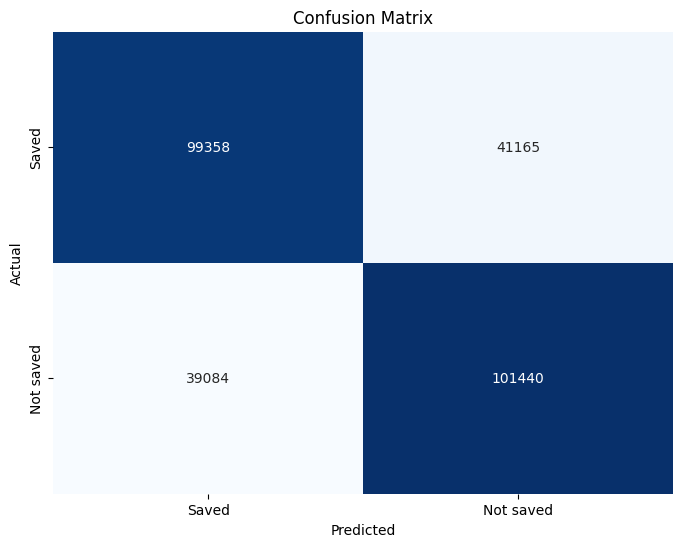

8783/8783 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step


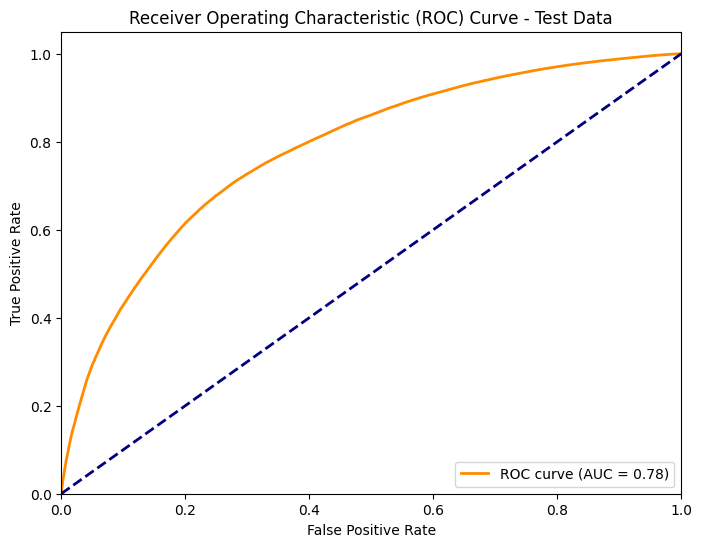

In [102]:
# Evaluate the best model on the test data
y_pred = best_model_mlp.predict(X_test)
y_pred_train = best_model_mlp.predict(X_trainval)

# Compute the evaluation metrics
train_accuracy = accuracy_score(y_trainval, y_pred_train)
train_precision = precision_score(y_trainval, y_pred_train, average='weighted')
train_recall = recall_score(y_trainval, y_pred_train, average='weighted')
train_f1 = f1_score(y_trainval, y_pred_train, average='weighted')
train_conf_matrix = confusion_matrix(y_trainval, y_pred_train)[::-1, ::-1]
train_class_report = classification_report(y_trainval, y_pred_train)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)[::-1, ::-1]
class_report = classification_report(y_test, y_pred)

# Print the results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print(f"Confusion Matrix: \n{train_conf_matrix}")
print(f"Classification Report: \n{train_class_report}")

print("Test Set Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Classification Report: \n{class_report}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Saved', 'Not saved'], yticklabels=['Saved', 'Not saved'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and ROC area for test data
y_prob = best_model_mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc='lower right')
plt.show()

## Feature Importance

In [ ]:
# Compute permutation importance
result = permutation_importance(best_model_mlp, X_test, y_test, n_repeats=1, random_state=42)

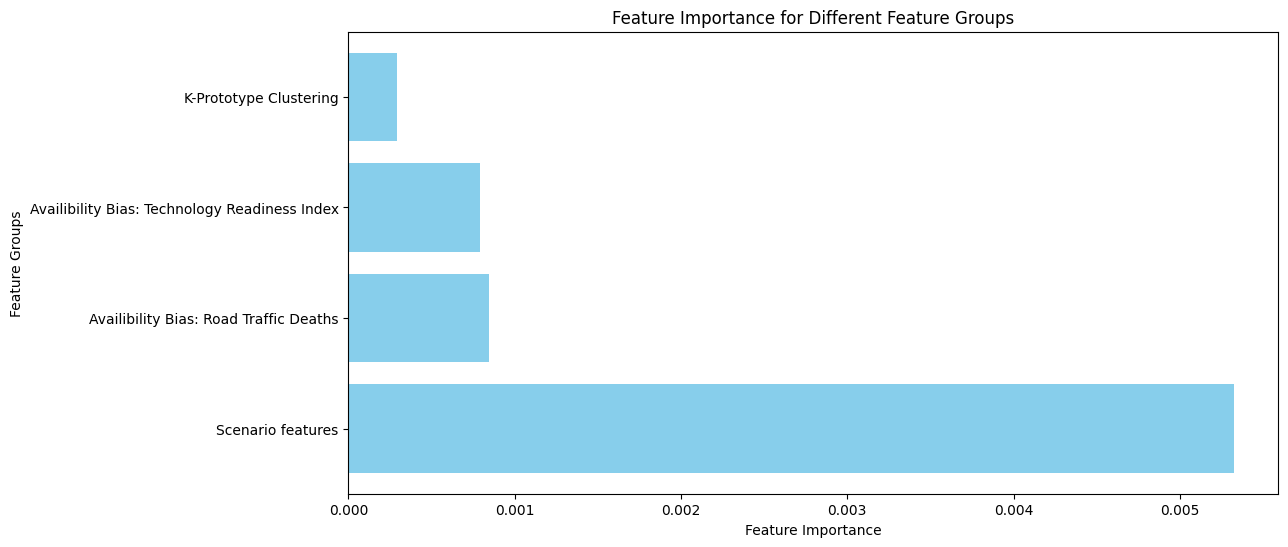

In [56]:
# Scenario feature importance
scenario_features = ['PedPed', 'Barrier', 'NumberOfCharacters', 'DiffNumberOFCharacters', 'Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', 'AttributeLevel_Female', 'AttributeLevel_Fit', 'AttributeLevel_High', 'AttributeLevel_Hoomans', 'AttributeLevel_Less', 'AttributeLevel_Low', 'AttributeLevel_Male', 'AttributeLevel_More', 'AttributeLevel_Old', 'AttributeLevel_Pets', 'AttributeLevel_Rand', 'AttributeLevel_Young', 'ScenarioTypeStrict_Fitness', 'ScenarioTypeStrict_Gender', 'ScenarioTypeStrict_Random', 'ScenarioTypeStrict_Social Status', 'ScenarioTypeStrict_Species', 'ScenarioTypeStrict_Utilitarian', 'CrossingSignal_1', 'CrossingSignal_2']
scenario_indices = [X_trainval.columns.get_loc(feature) for feature in scenario_features]
scenario_feature_importance = result.importances_mean[scenario_indices].mean()

# Availibility bias road traffic deaths feature importance
road_traffic_features = ['Total', 'Males', 'Females', 'Passengers', 'Pedestrians']
road_traffic_indices = [X_trainval.columns.get_loc(feature) for feature in road_traffic_features]
road_traffic_feature_importance = result.importances_mean[road_traffic_indices].mean()

# Availibility bias technology readiness index feature importance
technology_readiness_features = ['Finance_access', 'ICT', 'Industry_activity', 'Overall_index', 'Research_and_development', 'Skills']
technology_readiness_indices = [X_trainval.columns.get_loc(feature) for feature in technology_readiness_features]
technology_readiness_feature_importance = result.importances_mean[technology_readiness_indices].mean()

# K-protoype clustering feature importance
k_prototype_features = ['Clusters_1', 'Clusters_2']
k_prototype_indices = [X_trainval.columns.get_loc(feature) for feature in k_prototype_features]
k_prototype_feature_importance = result.importances_mean[k_prototype_indices].mean()

group_names = ['Scenario features', 'Availibility Bias: Road Traffic Deaths', 'Availibility Bias: Technology Readiness Index', 'K-Prototype Clustering']
group_importances = [scenario_feature_importance, road_traffic_feature_importance, technology_readiness_feature_importance, k_prototype_feature_importance]

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.barh(group_names, group_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Groups')
plt.title('Feature Importance for Different Feature Groups')
plt.show()

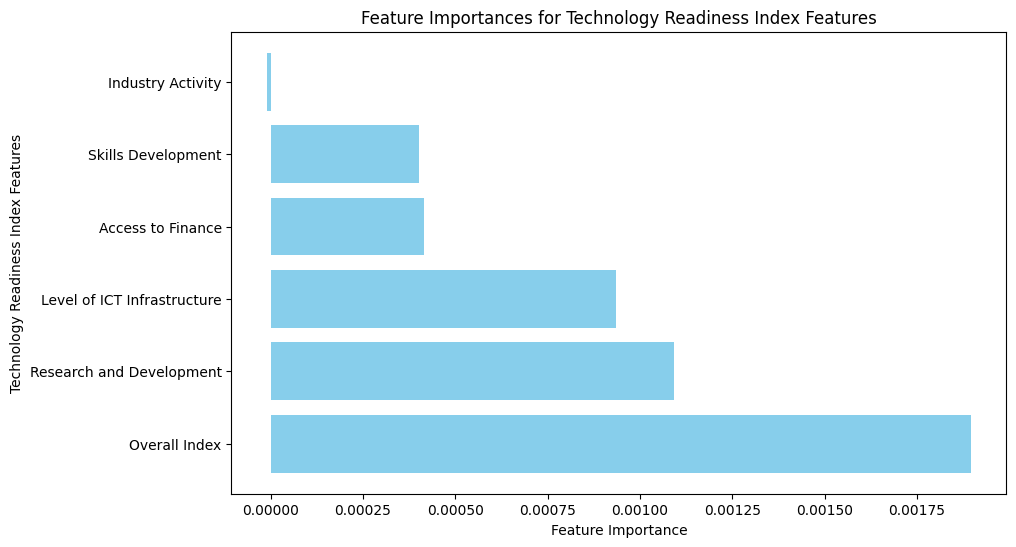

In [59]:
feature_names = ['Finance_access', 'ICT', 'Industry_activity', 'Overall_index', 'Research_and_development', 'Skills']
feature_name_map = {'Finance_access': 'Access to Finance', 'ICT': 'Level of ICT Infrastructure', 'Industry_activity': 'Industry Activity', 'Overall_index': 'Overall Index', 'Research_and_development': 'Research and Development', 'Skills': 'Skills Development'}

selected_indices = [X_trainval.columns.get_loc(feature) for feature in feature_names]

# Plot feature importances
feature_importances = result.importances_mean[selected_indices]

# Sort the feature importances and names in descending order
sorted_indices = np.argsort(feature_importances)[::-1] 
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_name_map[feature_names[i]] for i in sorted_indices]  

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Technology Readiness Index Features")
plt.title("Feature Importances for Technology Readiness Index Features")
plt.show()

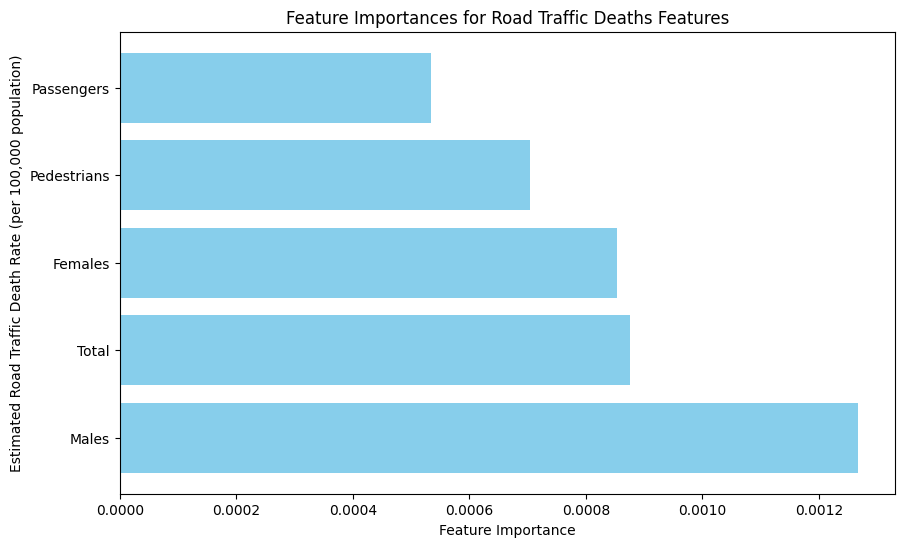

In [58]:
feature_names = ['Total', 'Males', 'Females', 'Passengers', 'Pedestrians']

selected_indices = [X_trainval.columns.get_loc(feature) for feature in feature_names]

# Plot feature importances
feature_importances = result.importances_mean[selected_indices]

# Sort the feature importances and names in descending order
sorted_indices = np.argsort(feature_importances)[::-1]  # Get indices for descending order
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Estimated Road Traffic Death Rate (per 100,000 population)")
plt.title("Feature Importances for Road Traffic Deaths Features")
plt.show()

In [40]:
# Create a DataFrame with feature names and their importance
importance_df = pd.DataFrame({'Feature': X_test.columns,'Importance': result.importances_mean})

# Sort the table by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df

,Feature,Importance
0,AttributeLevel_Young,0.029611
1,CrossingSignal_2,0.028102
2,CrossingSignal_1,0.019545
3,AttributeLevel_Hoomans,0.019292
4,DiffNumberOFCharacters,0.018541
5,AttributeLevel_More,0.015901
6,Barrier,0.015677
7,AttributeLevel_High,0.011763
8,AttributeLevel_Fit,0.009006
9,NumberOfCharacters,0.008575


## Error Analysis

In [ ]:
# Prepare the dataset for error analysis
# Add y_test and y_pred to the test dataset
test_df = X_test.copy()
test_df['y_test'] = y_test
test_df['y_pred'] = y_pred
test_df['y_prob'] = y_prob
test_df['y_diff'] = test_df['y_test'] - test_df['y_pred']
test_df['y_diff'] = test_df['y_diff'].apply(lambda x: 1 if x == 0 else 0)

# Inverse transform the normalized columns
scaler = joblib.load('scaler.pkl')
num_cols = ['NumberOfCharacters', 'DiffNumberOFCharacters', 'Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', 'Finance_access', 'ICT', 'Industry_activity', 'Overall_index', 'Research_and_development', 'Skills', 'Total', 'Males', 'Females', 'Passengers', 'Pedestrians']
test_df[num_cols] = scaler.inverse_transform(test_df[num_cols])

test_df

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

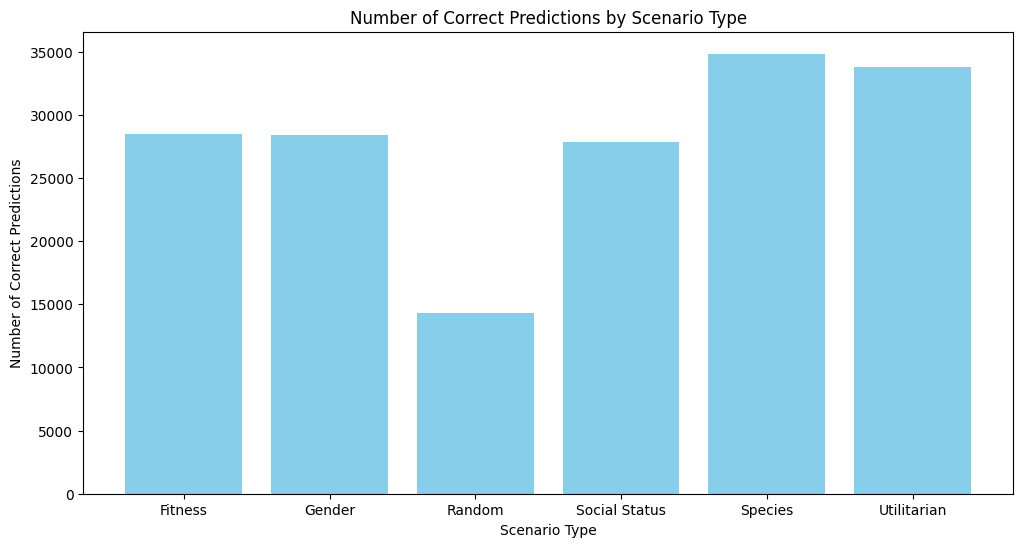

In [ ]:
# Count how many times y_diff is 1 and ScenarioTypeStrict_Fitness is 1
Fitness_diff = test_df[(test_df['y_diff'] == 1) & (test_df['ScenarioTypeStrict_Fitness'] == 1)].shape[0]
Gender_diff = test_df[(test_df['y_diff'] == 1) & (test_df['ScenarioTypeStrict_Gender'] == 1)].shape[0]
Random_diff = test_df[(test_df['y_diff'] == 1) & (test_df['ScenarioTypeStrict_Random'] == 1)].shape[0]
Socialstatus_diff = test_df[(test_df['y_diff'] == 1) & (test_df['ScenarioTypeStrict_Social Status'] == 1)].shape[0]
Species_diff = test_df[(test_df['y_diff'] == 1) & (test_df['ScenarioTypeStrict_Species'] == 1)].shape[0]
Utilitarian_diff = test_df[(test_df['y_diff'] == 1) & (test_df['ScenarioTypeStrict_Utilitarian'] == 1)].shape[0]

# Make a bar plot of the counts
plt.figure(figsize=(12, 6))
plt.bar(['Fitness', 'Gender', 'Random', 'Social Status', 'Species', 'Utilitarian'], [Fitness_diff, Gender_diff, Random_diff, Socialstatus_diff, Species_diff, Utilitarian_diff], color="skyblue")
plt.xlabel("Scenario Type")
plt.ylabel("Number of Correct Predictions")
plt.title("Number of Correct Predictions by Scenario Type")
plt.show()

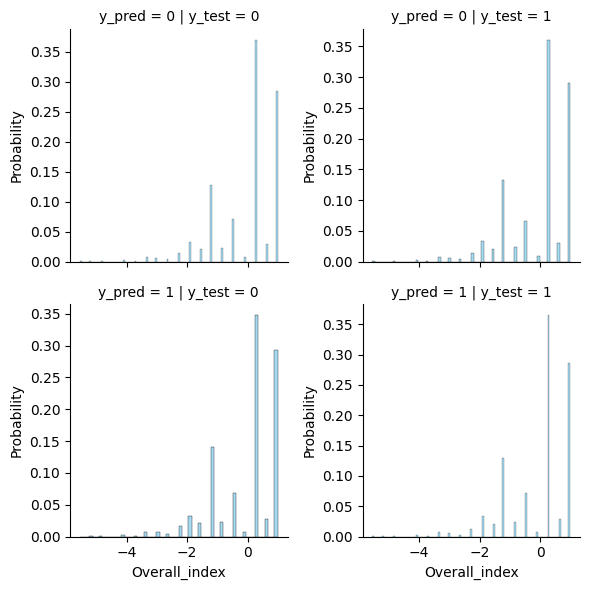

In [92]:
g = sns.FacetGrid(test_df, col = 'y_test', row = 'y_pred', sharey=False)
g.map(sns.histplot, 'Overall_index', color = "skyblue", stat = 'probability')

#for ax in g.axes.flat:
#    ax.set_ylim(0, 0.16)

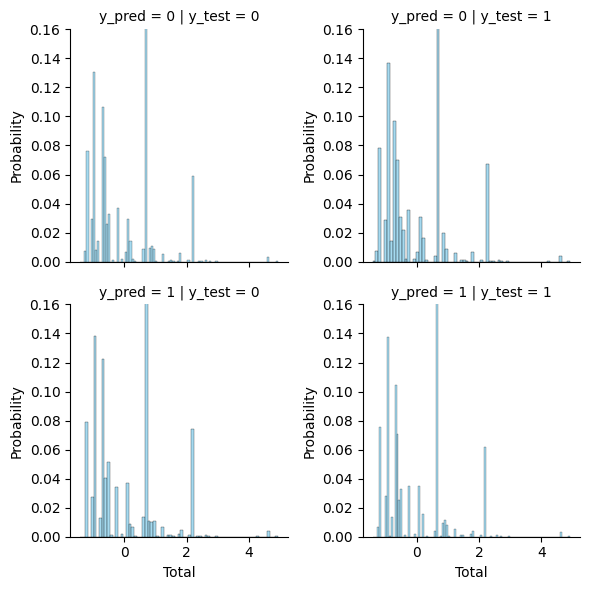

In [88]:
g = sns.FacetGrid(test_df, col = 'y_test', row = 'y_pred', sharey=False)
g.map(sns.histplot, 'Total', color = "skyblue", stat = 'probability')

for ax in g.axes.flat:
    ax.set_ylim(0, 0.16)

/var/folders/1r/syrrrqbj2cgc7y5d1z2fgb3r0000gn/T/ipykernel_21956/1140285972.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct_predictions = test_df[test_df['y_diff'] == 1].groupby(pd.cut(test_df['Overall_index'], bins=10)).size()


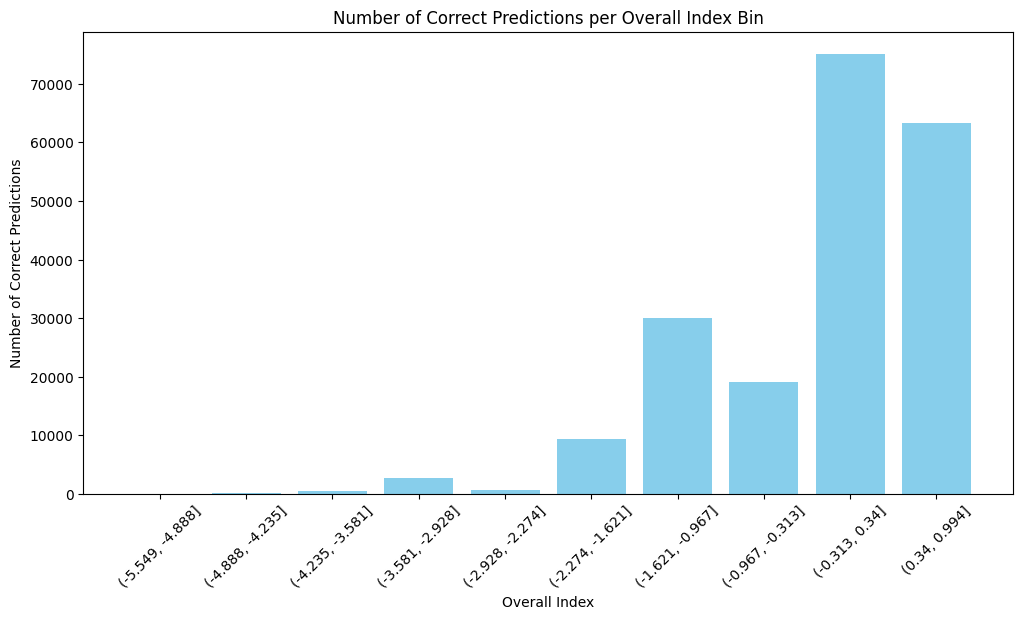

In [100]:
# Count the number of correct predictions per bin of 'Overall_index'ArithmeticError'
correct_predictions = test_df[test_df['y_diff'] == 1].groupby(pd.cut(test_df['Overall_index'], bins=10)).size()

# Change it to a DataFrame
correct_predictions = correct_predictions.reset_index()
correct_predictions.columns = ['Overall_index', 'Count']

# Convert intervals to strings for plotting
correct_predictions['Overall_index'] = correct_predictions['Overall_index'].astype(str)

# Plot the number of correct predictions per bin
plt.figure(figsize=(12, 6))
plt.bar(correct_predictions['Overall_index'], correct_predictions['Count'], color='skyblue')
plt.xlabel('Overall Index')
plt.ylabel('Number of Correct Predictions')
plt.title('Number of Correct Predictions per Overall Index Bin')
plt.xticks(rotation=45)
plt.show()

/var/folders/1r/syrrrqbj2cgc7y5d1z2fgb3r0000gn/T/ipykernel_21956/442598001.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct_predictions = test_df[test_df['y_diff'] == 1].groupby(pd.cut(test_df['Total'], bins=10)).size()


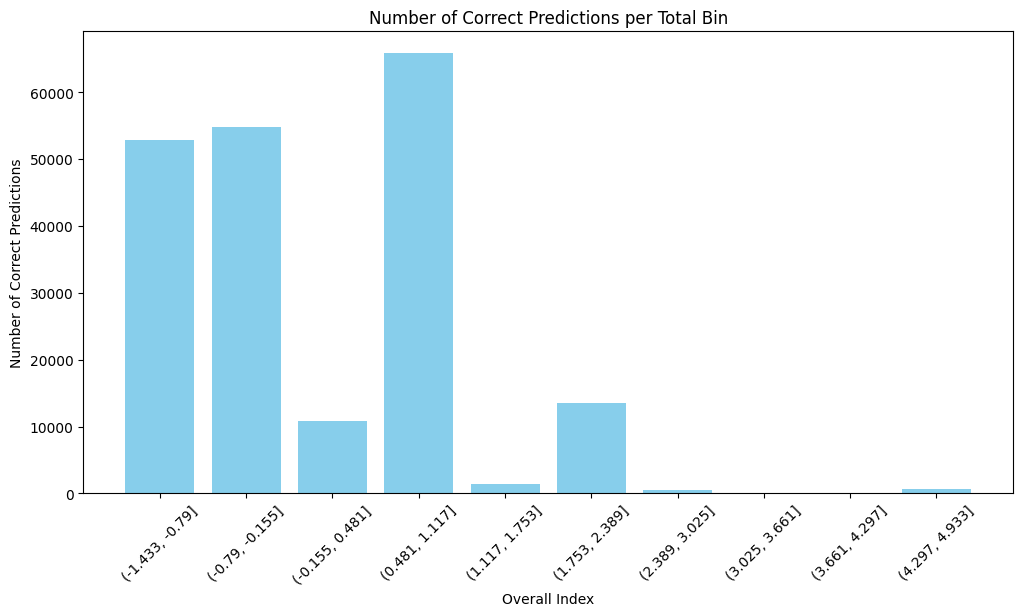

In [101]:
# Count the number of correct predictions per bin of 'Overall_index'ArithmeticError'
correct_predictions = test_df[test_df['y_diff'] == 1].groupby(pd.cut(test_df['Total'], bins=10)).size()

# Change it to a DataFrame
correct_predictions = correct_predictions.reset_index()
correct_predictions.columns = ['Total', 'Count']

# Convert intervals to strings for plotting
correct_predictions['Total'] = correct_predictions['Total'].astype(str)

# Plot the number of correct predictions per bin
plt.figure(figsize=(12, 6))
plt.bar(correct_predictions['Total'], correct_predictions['Count'], color='skyblue')
plt.xlabel('Overall Index')
plt.ylabel('Number of Correct Predictions')
plt.title('Number of Correct Predictions per Total Bin')
plt.xticks(rotation=45)
plt.show()

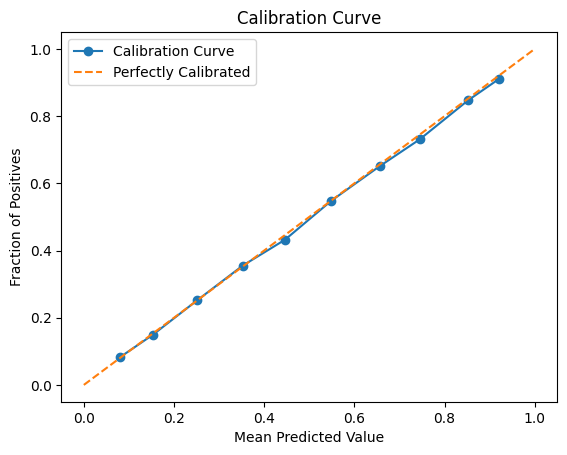

In [103]:
from sklearn.calibration import calibration_curve

# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()